In [3]:
import os
import cooler
import numpy as np
import pandas as pd
from scipy.stats import norm, zscore
from scipy import ndimage as nd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

from itertools import cycle, islice
import xarray as xr
from glob import glob
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#mpl.rcParams['font.family'] = 'sans-serif'
#mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [4]:
ct = 'Oligo_NN'

In [5]:
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:-1]

In [6]:
leg = [f'{ct}.8wk', f'{ct}.9mo', f'{ct}.18mo']

In [7]:
indir = '/data/female-amb/loop/'
ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
cdir = f'/home/qzeng_salk_edu/project/240204-redo-compartment/Call.DiffComp.CellType.Age/{ct}'

In [8]:
chrom_size_path = f'/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

In [9]:
genemeta = pd.read_csv('/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t', index_col = 'gene_name')
genemeta = genemeta[~genemeta.index.duplicated(keep='first')]
genemeta.head()

,chrom,source,feature,start,end,score,strand,phase,gene_id,transcript_id,...,gene_status,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,mgi_id,havana_gene,tag
gene_name,,,,,,,,,,,,,,,,,,,,,
4933401J01Rik,chr1,HAVANA,gene,3073253,3074322,.,+,.,ENSMUSG00000102693.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:1918292,OTTMUSG00000049935.1,NaN
Gm26206,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,ENSMUSG00000064842.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,MGI:5455983,NaN,NaN
Xkr4,chr1,HAVANA,gene,3205901,3671498,.,-,.,ENSMUSG00000051951.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:3528744,OTTMUSG00000026353.2,NaN
Gm18956,chr1,HAVANA,gene,3252757,3253236,.,+,.,ENSMUSG00000102851.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
Gm37180,chr1,HAVANA,gene,3365731,3368549,.,-,.,ENSMUSG00000103377.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:5610408,OTTMUSG00000049960.1,NaN


In [28]:
gtmp = 'Il33'
lslop, rslop = 250000, 250000

chrom = genemeta.loc[gtmp, 'chrom']
if genemeta.loc[gtmp, 'strand']=='+':
    tss = genemeta.loc[gtmp, 'start']
    tes = genemeta.loc[gtmp, 'end']
else:
    tss = genemeta.loc[gtmp, 'end']
    tes = genemeta.loc[gtmp, 'start']

#tss, tes = tss -2000, tes + 2000
ll, rr = (tss - lslop), (tss + rslop)
print(chrom, ll, rr, genemeta.loc[gtmp, 'strand'])

chr19 29675114 30175114 +


In [29]:
region = f"{chrom}:{ll}-{rr}"
region

'chr19:29675114-30175114'

In [30]:
ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
loopall = pd.read_hdf(f'{ldir}/merged_loop.hdf', key='data')
sell = ((loopall[0]==chrom) & 
        (zscore(np.log(loopall['Qanova']))>norm.isf(0.15)) & 
        (zscore(np.log(loopall['Tanova']))>norm.isf(0.15)) & 
        (loopall[1]>ll) & (loopall[5]<rr))
print(sell.sum())

20


In [31]:
dstall = []
resolution = 5000

for group in leg:
    cool = cooler.Cooler(f'/data/female-amb/AMB.CoolFiles/CellType.Age.Raw.5kb.mcool/{group}.raw.mcool::resolutions/{resolution}')
    Q = cool.matrix(balance=False, sparse=True).fetch(region).toarray()
    Q = Q - np.diag(np.diag(Q))
    dst = nd.rotate(Q, 45, order=0, reshape=True, prefilter=False, cval=0)
    dstall.append(dst)

In [32]:
dst.max()

60

Text(0.5, 0.98, 'chr19:29675114-30175114')

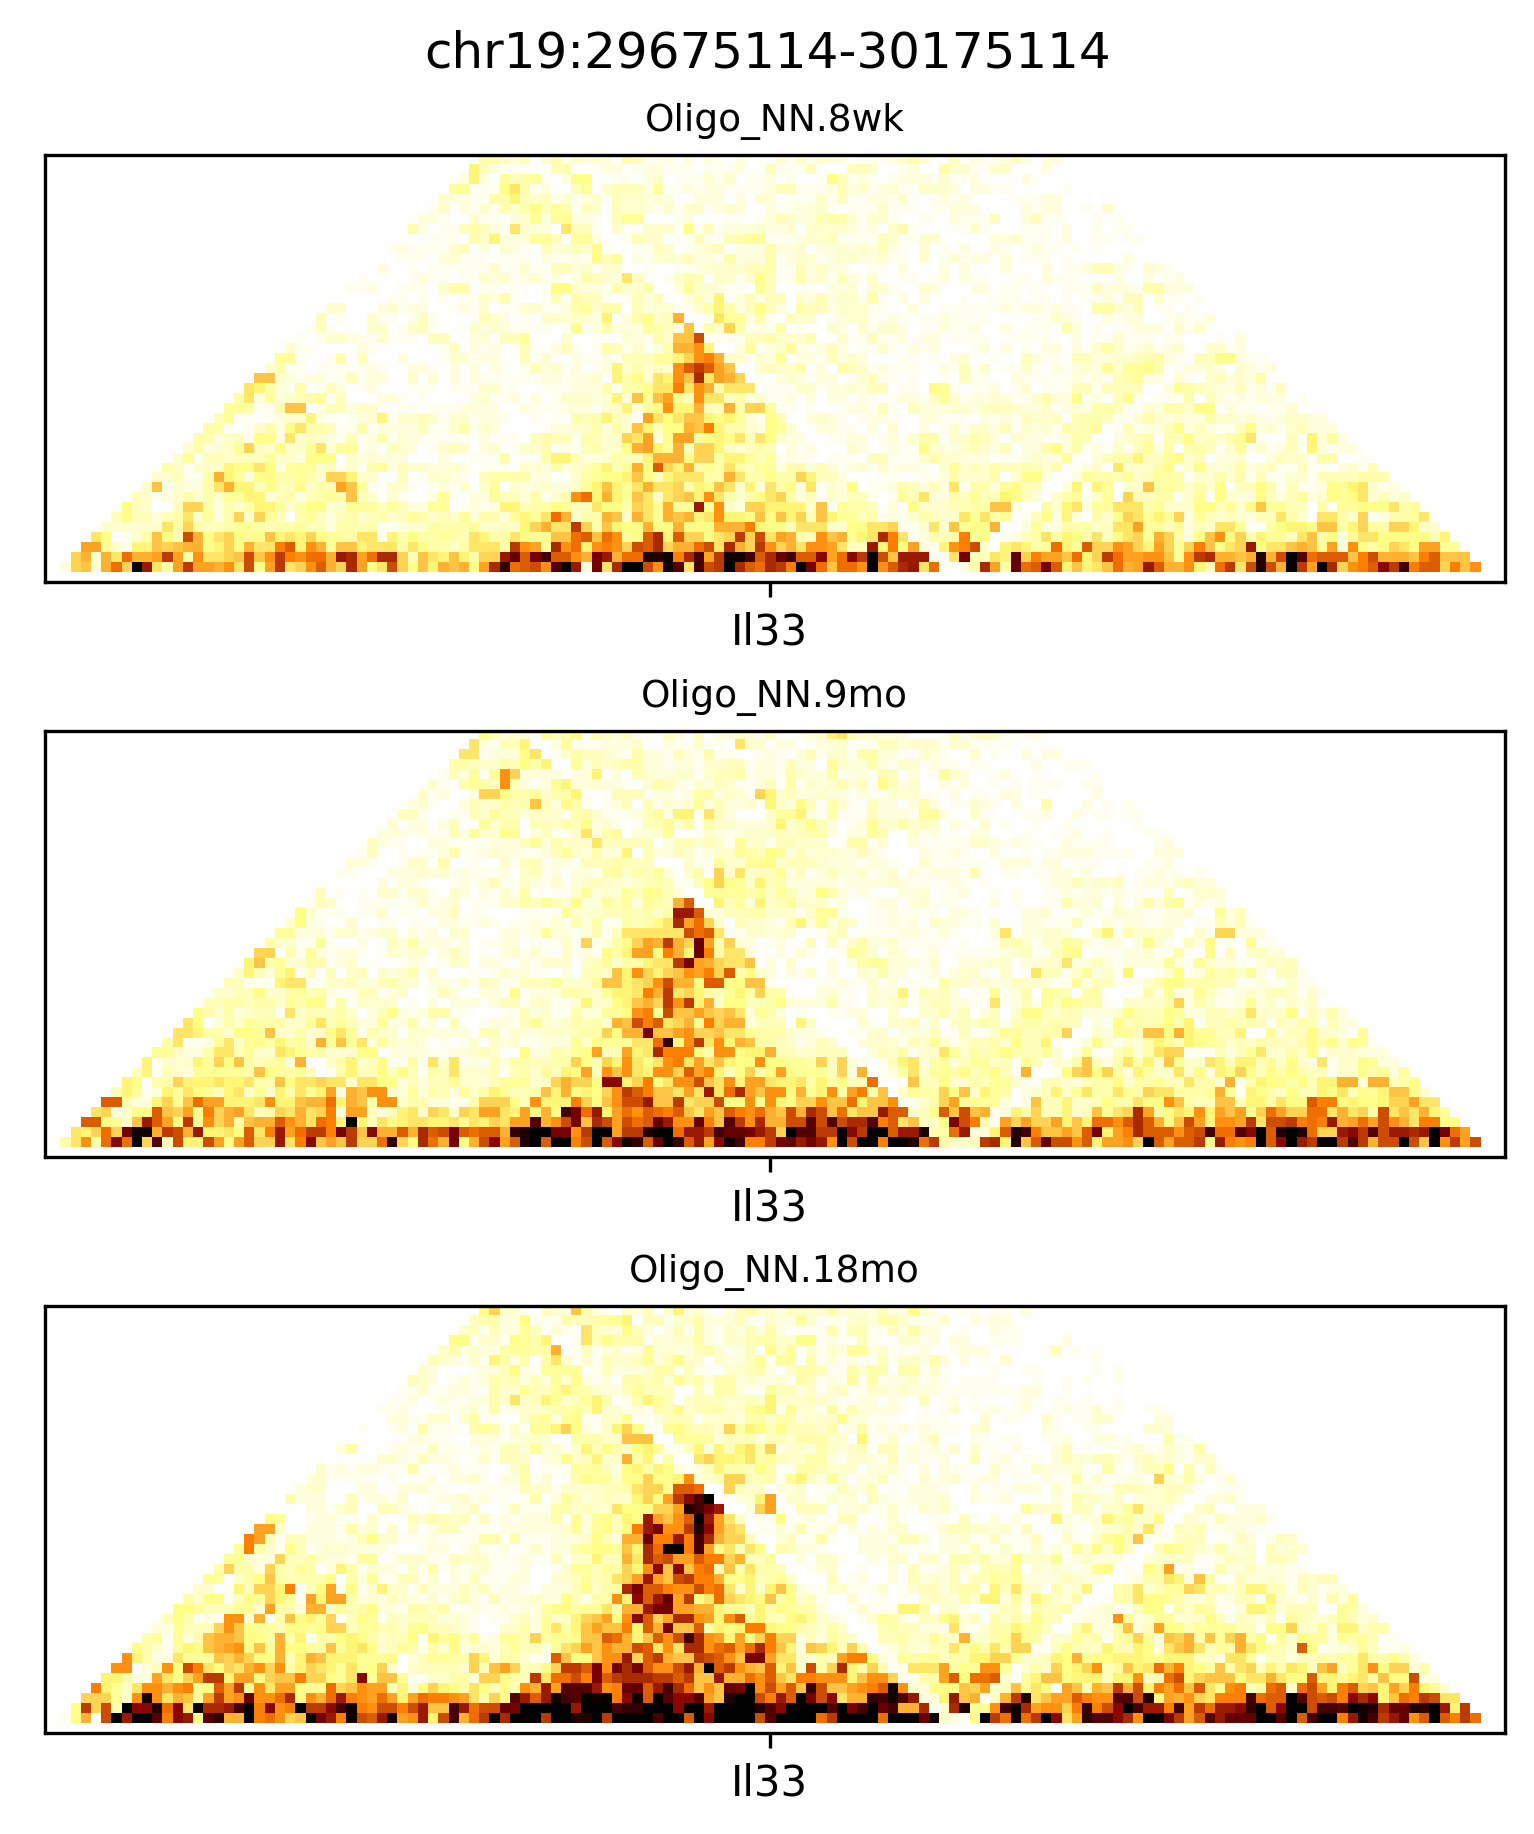

In [33]:
fig, axes = plt.subplots(ncols = 1, nrows = len(leg), figsize=(5, 6), constrained_layout = True, dpi = 300)

for i in range(len(leg)):
    ax = axes[i]
    ax.axis('equal')
    ax.set_title(leg[i], fontsize=9)
    
    #img = ax.imshow(dstall[i][:dstall[i].shape[0]//2], cmap='afmhot_r', vmin=0, vmax=30, aspect='auto')
    img = ax.imshow(dstall[i], cmap='afmhot_r', vmin=0, vmax=30, aspect='auto')
    h = len(dstall[i])
    ax.set_ylim([0.5*h, 0.2*h])
    ax.set_xlim([0, h])
    ax.set_yticks([])
    ax.set_yticklabels([])


    mid_point = dstall[i].shape[1] // 2  # Since we're only showing the upper half
    
    # Set the x-ticks and labels
    ax.set_xticks([mid_point])
    ax.set_xticklabels(['Il33'])
plt.suptitle(region)  
#fig.savefig(f'Fig1.Il33.Example.pdf', transparent=True, bbox_inches = 'tight')

In [19]:
import sys
print("Python executable:", sys.executable)


Python executable: /opt/conda/bin/python


In [20]:
import pyGenomeTracks.tracks as tracks

ModuleNotFoundError: No module named 'pyGenomeTracks'

In [ ]:
# Configuration for the gene track
config = {
    'file': 'path/to/your/Mus_musculus.GRCm38.102.gtf',
    'title': 'Gene Annotations',
    'height': 4,
    'color': 'black',
    'fontSize': 10,
    'geneRows': 10,
    'file_type': 'gtftxt'
}

# Initialize the GeneTrack object
gene_track = GeneTrack(config)

# Specify the region to plot
region = 'chr1:10000000-10500000'

# Generate the plot
output_file = 'output.png'
tracks.create_tracks([gene_track], region, output_file)